In [0]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sample_data/mnist_train_small.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
len(df)

20000

label: 1


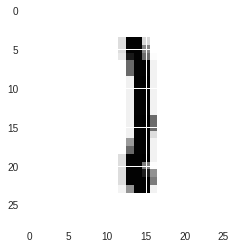

In [4]:
ix = random.randint(0, len(df)-1)
label, pixels = df.loc[ix][0], df.loc[ix][1:]
img = np.array(pixels).reshape((28,28))
print('label: ' + str(label))
plt.imshow(img)

In [5]:
# transforming df for easier manipulation
labels, imgs = [], []
for index, row in df.iterrows():
    label, pixels = row[0], row[1:]
    img = np.array(pixels)
    labels.append(label)
    imgs.append(img)
df2 = pd.DataFrame({'label': labels, 'img': imgs})
#df2 = df2[:10000]
df2.head()

,img,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5


label: 7


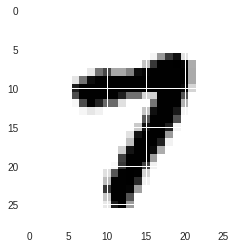

In [6]:
# checking images using new df structure
ix = random.randint(0, len(df2)-1)
img = df2.loc[ix].img.reshape((28,28))
label = df2.loc[ix].label
print('label: ' + str(label))
plt.imshow(img)

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df2, test_size=0.2, shuffle=True)

print(len(train_df), len(test_df))

16000 4000


In [8]:
train_df.head()

,img,label
10255,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
5493,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7
14666,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
17154,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
9005,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [10]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [0]:
# create torch dataset
# definition of torch dataset? #TODO: research
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
  def __init__(self, imgs, labels):
    super(MNISTDataset, self).__init__()
    self.imgs = imgs
    self.labels = labels
    
  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, ix):
    img = self.imgs[ix]
    label = self.labels[ix]
    return torch.from_numpy(img).float(), label

In [12]:
dataset = {
    'train': MNISTDataset(train_df.img.values, train_df.label.values),
    'test': MNISTDataset(test_df.img.values, test_df.label.values)
} 

len(dataset['train'])

16000

torch.Size([784]) torch.float32
5


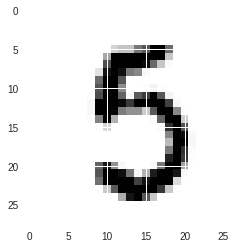

In [13]:
# againg checking image, now based on torch dataset
ix = random.randint(0, len(dataset['train'])-1)
img, label = dataset['train'][ix]
print(img.shape, img.dtype)
print(label)
plt.imshow(img.reshape((28,28)))

In [14]:
# create model
import torch.nn as nn

def block(in_f, out_f):
  return nn.Sequential(
      nn.Linear(in_f, out_f),
      nn.BatchNorm1d(out_f),
      nn.ReLU(inplace=True),
      #nn.Dropout(),
  )

model = nn.Sequential(
  block(784,512),
  block(512,256),
  block(256,128),
  nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=3, min_lr=0.0001, verbose=True)

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(dataset['test'], batch_size=32, shuffle=False, num_workers=4),
}

In [16]:
# train
best_acc, stop, early_stop = 0, 0, 10
for e in range(100):
    
  model.train()
  total_loss = []
  for imgs, labels in tqdm(dataloader['train']):
    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    optimizer.zero_grad()
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.data)
    
  model.eval()
  val_loss, acc = [], 0.
  with torch.no_grad():
    for imgs, labels in tqdm(dataloader['test']):
      imgs, labels = imgs.to(device), labels.to(device)
      preds = model(imgs)
      loss = criterion(preds, labels)
      val_loss.append(loss.data)
      _, preds = torch.max(preds, 1)
      acc += (preds == labels).sum().item()
      
  acc /= len(dataset['test'])
  if acc > best_acc:
    print('\n Best model ! saved.')
    torch.save(model.state_dict(), 'best_model.pt')
    best_acc = acc
    stop = -1
  
  stop += 1
  if stop >= early_stop:
    break
    
  scheduler.step(acc)
    
  print('\n Epoch {}, Training loss: {:4f}, Val loss: {:4f}, Val acc: {:4f}'.format(
      e+1, np.array(total_loss).mean(), np.array(val_loss).mean(), acc))
  
print('\n Best model with acc: {}'.format(best_acc))

  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 1, Training loss: 0.534512, Val loss: 0.322474, Val acc: 0.912750


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 2, Training loss: 0.328471, Val loss: 0.209036, Val acc: 0.946750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 3, Training loss: 0.259496, Val loss: 0.264894, Val acc: 0.927500


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 4, Training loss: 0.217841, Val loss: 0.214145, Val acc: 0.943750


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 5, Training loss: 0.201812, Val loss: 0.185450, Val acc: 0.949250


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 6, Training loss: 0.186579, Val loss: 0.186246, Val acc: 0.953250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 7, Training loss: 0.155304, Val loss: 0.209035, Val acc: 0.944750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 8, Training loss: 0.144107, Val loss: 0.257484, Val acc: 0.948000


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 9, Training loss: 0.153265, Val loss: 0.163909, Val acc: 0.961250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 10, Training loss: 0.129769, Val loss: 0.190650, Val acc: 0.958500


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 11, Training loss: 0.140383, Val loss: 0.188405, Val acc: 0.958000


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 12, Training loss: 0.123966, Val loss: 0.198522, Val acc: 0.954750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch    12: reducing learning rate of group 0 to 1.0000e-02.

 Epoch 13, Training loss: 0.124794, Val loss: 0.207284, Val acc: 0.959250


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 14, Training loss: 0.057628, Val loss: 0.157566, Val acc: 0.965750


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 15, Training loss: 0.038763, Val loss: 0.141579, Val acc: 0.969000


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 16, Training loss: 0.034263, Val loss: 0.142151, Val acc: 0.969500


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 17, Training loss: 0.029956, Val loss: 0.134928, Val acc: 0.971750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 18, Training loss: 0.025603, Val loss: 0.140055, Val acc: 0.971500


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 19, Training loss: 0.021748, Val loss: 0.150656, Val acc: 0.971250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 20, Training loss: 0.022106, Val loss: 0.149522, Val acc: 0.970500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.0000e-03.

 Epoch 21, Training loss: 0.018569, Val loss: 0.150352, Val acc: 0.970250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 22, Training loss: 0.014630, Val loss: 0.151768, Val acc: 0.971750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 23, Training loss: 0.014620, Val loss: 0.144805, Val acc: 0.971750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 24, Training loss: 0.014841, Val loss: 0.150933, Val acc: 0.970750


  0%|          | 0/500 [00:00<?, ?it/s]


 Best model ! saved.

 Epoch 25, Training loss: 0.012287, Val loss: 0.148000, Val acc: 0.973500


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 26, Training loss: 0.012438, Val loss: 0.154150, Val acc: 0.971500


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 27, Training loss: 0.013748, Val loss: 0.148070, Val acc: 0.971000


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 28, Training loss: 0.011424, Val loss: 0.157474, Val acc: 0.970500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch    28: reducing learning rate of group 0 to 1.0000e-04.

 Epoch 29, Training loss: 0.011768, Val loss: 0.145952, Val acc: 0.972000


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 30, Training loss: 0.010749, Val loss: 0.148356, Val acc: 0.971250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 31, Training loss: 0.013788, Val loss: 0.158037, Val acc: 0.971250


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 32, Training loss: 0.014149, Val loss: 0.153336, Val acc: 0.971750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 33, Training loss: 0.013277, Val loss: 0.149593, Val acc: 0.971750


  0%|          | 0/500 [00:00<?, ?it/s]


 Epoch 34, Training loss: 0.012356, Val loss: 0.151306, Val acc: 0.970750


100%|██████████| 125/125 [00:00<00:00, 167.40it/s]


 Best model with acc: 0.9735


Ground Truth: 6, Prediction: 6


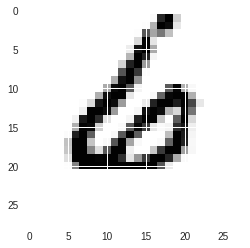

In [17]:
# test
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

ix = random.randint(0, len(dataset['test'])-1)
img, label = dataset['test'][ix]
pred = model(img.unsqueeze(0).to(device)).cpu()
pred_label = torch.argmax(pred)
print('Ground Truth: {}, Prediction: {}'.format(label, pred_label))
plt.imshow(img.reshape((28,28)))